In [1]:
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [2]:
def gen_base_anchors(base_size, ratios, scales):
    w = base_size
    h = base_size
    x_ctr = 0.5 * (w - 1)
    y_ctr = 0.5 * (h - 1)


    h_ratios = torch.sqrt(ratios)
    w_ratios = 1 / h_ratios
    ws = (w * w_ratios[:, None] * scales[None, :]).view(-1)
    hs = (h * h_ratios[:, None] * scales[None, :]).view(-1)

    base_anchors = torch.stack(
        [
            x_ctr - 0.5 * (ws - 1), y_ctr - 0.5 * (hs - 1),
            x_ctr + 0.5 * (ws - 1), y_ctr + 0.5 * (hs - 1)
        ],
        dim=-1).round()

    return base_anchors

In [3]:
def meshgrid(x, y):
    xx = x.repeat(len(y))
    yy = y.view(-1, 1).repeat(1, len(x)).view(-1)
    return xx, yy

In [4]:
def grid_anchors(base_anchors, featmap_size, stride=16, device='cuda'):
    base_anchors = base_anchors.to(device)

    feat_h, feat_w = featmap_size
    shift_x = torch.arange(0, feat_w, device=device) * stride
    shift_y = torch.arange(0, feat_h, device=device) * stride
    shift_xx, shift_yy = meshgrid(shift_x, shift_y)
    shifts = torch.stack([shift_xx, shift_yy, shift_xx, shift_yy], dim=-1)
    shifts = shifts.type_as(base_anchors)

    all_anchors = base_anchors[None, :, :] + shifts[:, None, :]
    all_anchors = all_anchors.view(-1, 4)
    return all_anchors, shifts

In [5]:
base_anchor = gen_base_anchors(32, torch.Tensor([0.5, 1, 2]), torch.Tensor([2]))
board = np.zeros((256, 256, 3))
all_anchors, shifts = grid_anchors(base_anchor, (32, 32), 16)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


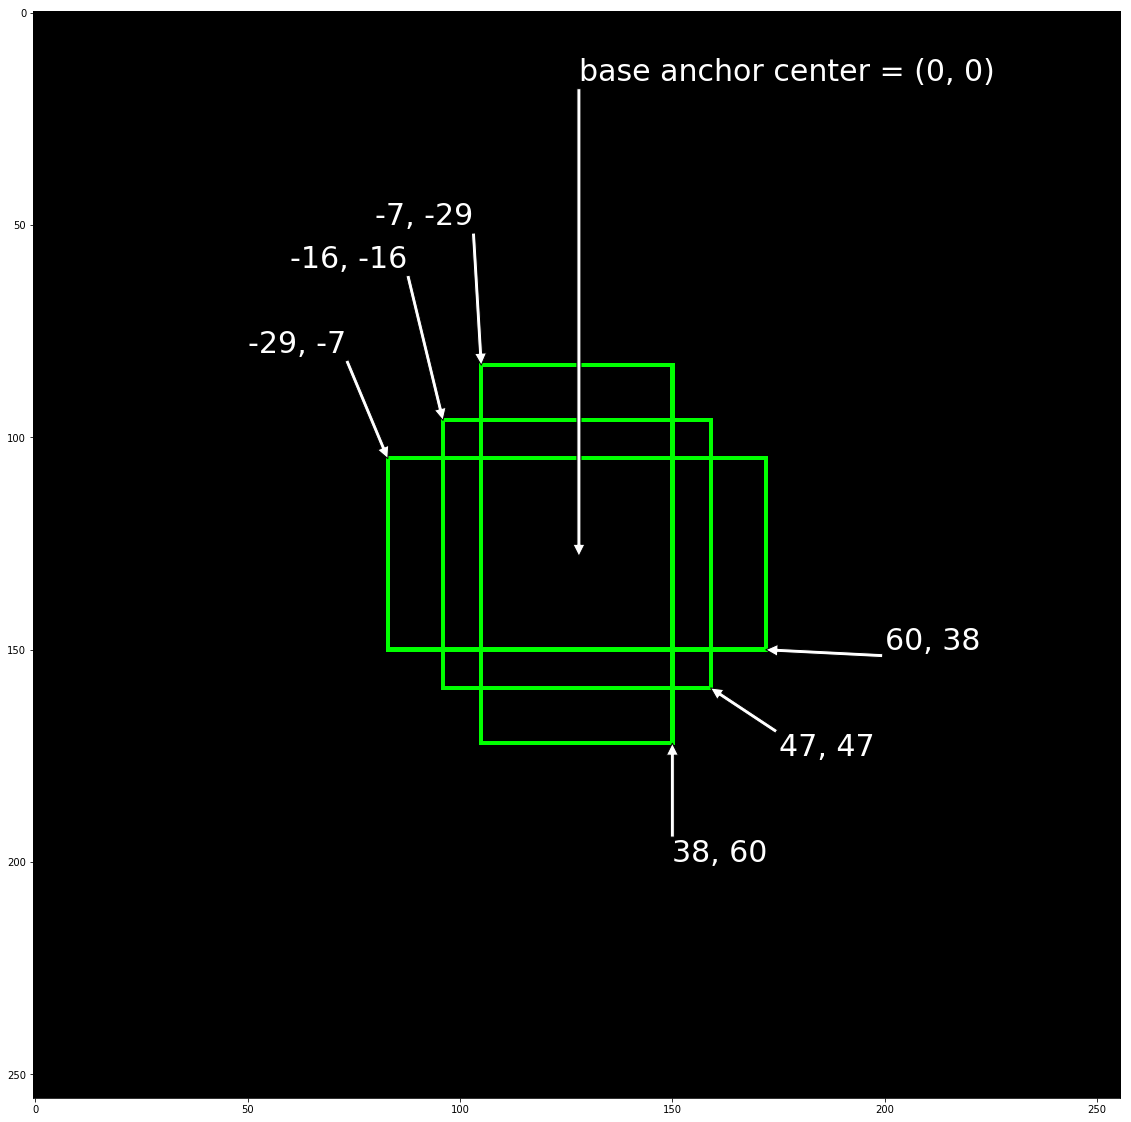

In [6]:
for anchor in base_anchor:
    x1, y1, x2, y2 = np.array(anchor) + 112
    cv2.rectangle(board, (x1, y1), (x2, y2), (0, 255, 0), 1)
    
board[board>255] = 255
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111)

ax.annotate('base anchor center = (0, 0)', xy=(128, 128), xytext=(128, 16), color='white',size=30,
            arrowprops=dict(facecolor='white', shrink=5),
            )

ax.annotate('-7, -29', xy=(105, 83), xytext=(80, 50), color='white',size=30,
            arrowprops=dict(facecolor='white', shrink=5),
            )
ax.annotate('-16, -16', xy=(96, 96), xytext=(60, 60), color='white',size=30,
            arrowprops=dict(facecolor='white', shrink=5),
            )
ax.annotate('-29, -7', xy=(83, 105), xytext=(50, 80), color='white',size=30,
            arrowprops=dict(facecolor='white', shrink=5),
            )

ax.annotate('38, 60', xy=(150, 172), xytext=(150, 200), color='white',size=30,
            arrowprops=dict(facecolor='white', shrink=5),
            )
ax.annotate('47, 47', xy=(159, 159), xytext=(175, 175), color='white',size=30,
            arrowprops=dict(facecolor='white', shrink=5),
            )
ax.annotate('60, 38', xy=(172, 150), xytext=(200, 150), color='white',size=30,
            arrowprops=dict(facecolor='white', shrink=5),
            )

plt.imshow(board)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


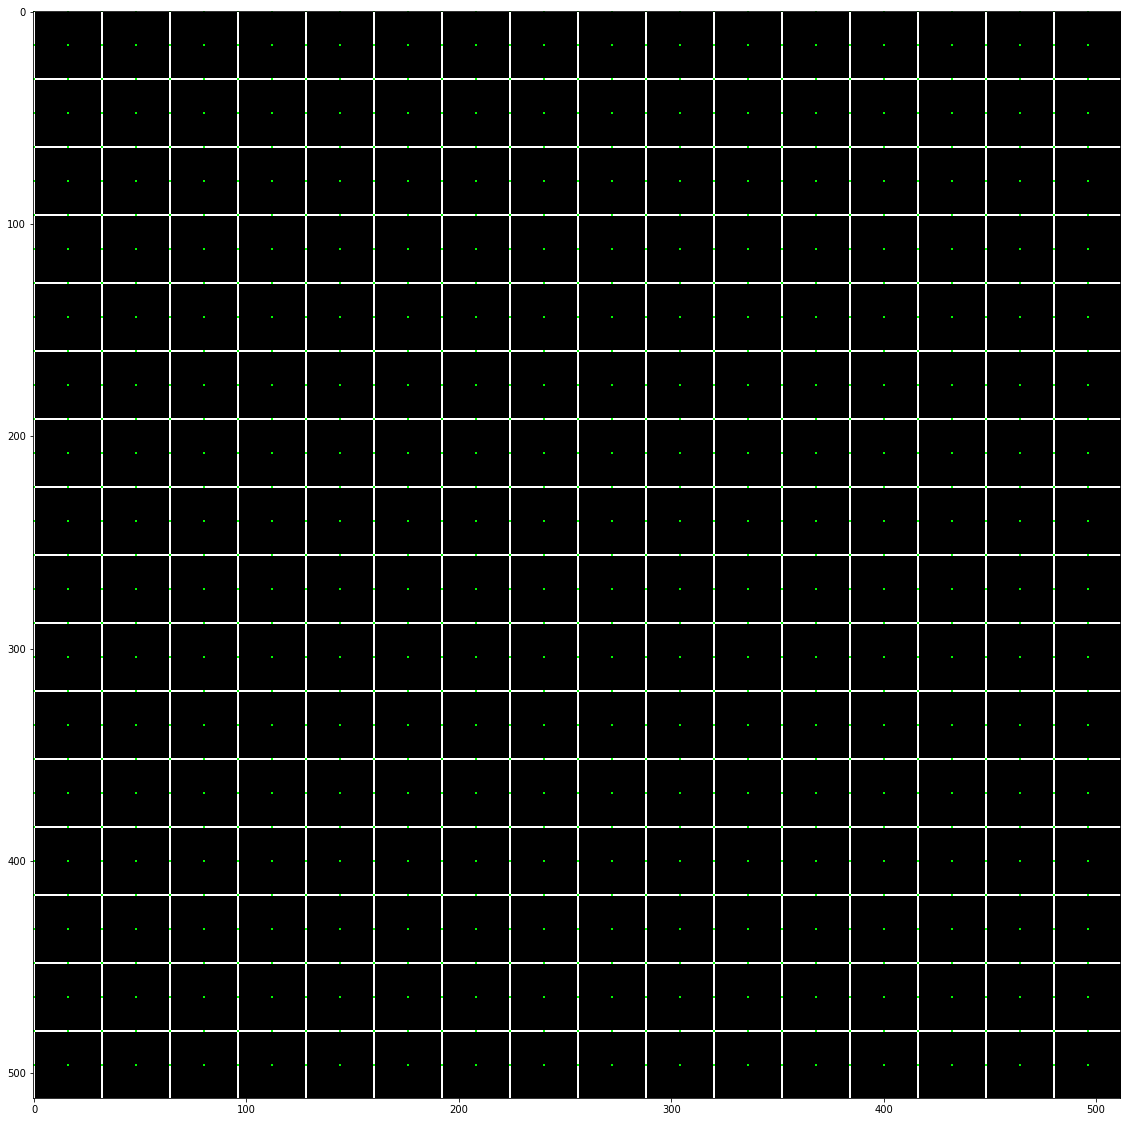

In [7]:
base_anchor = gen_base_anchors(32, torch.Tensor([0.5, 1, 2]), torch.Tensor([2, 2*2**(1/3), 2*2**(2/3)]))
board = np.zeros((512, 512, 3))
for i in range(512//32):
    board[i*32,:,:] = 255
    board[:,i*32,:] = 255
for shift in shifts.cpu():
    shift = np.array(shift, dtype=np.uint16)
    board[shift[1], shift[0]] = (255, 255, 0)
    board[shift[3], shift[2]] = (0, 255, 0)
board[board>255] = 255
plt.figure(figsize=(20,20))
plt.imshow(board)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


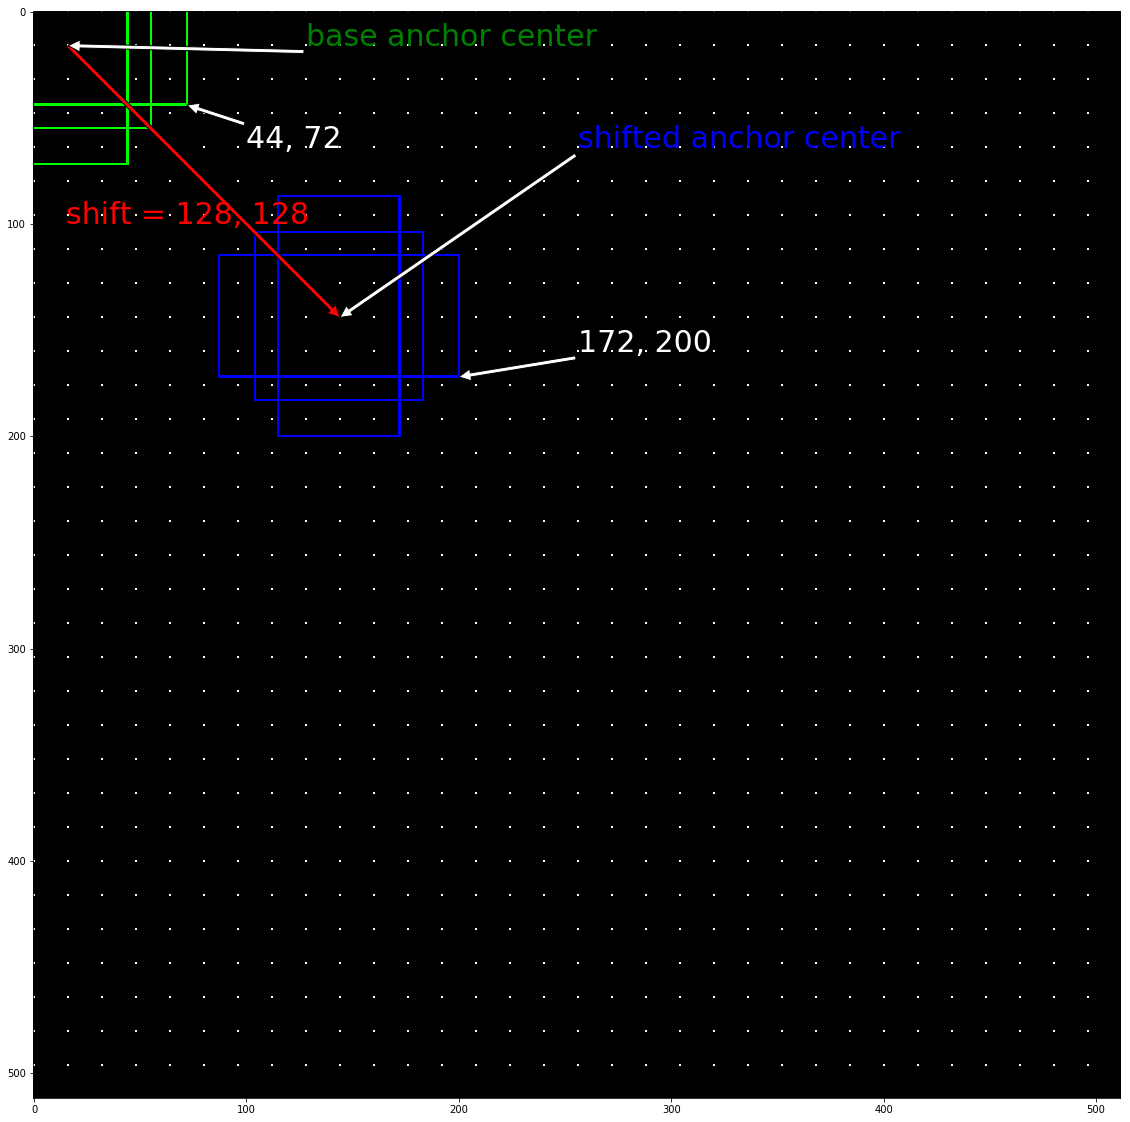

In [8]:
base_anchor = gen_base_anchors(32, torch.Tensor([0.5, 1, 2]), torch.Tensor([2*2**(1/3)]))
board = np.zeros((512, 512, 3))
for shift in shifts.cpu():
    shift = np.array(shift, dtype=np.uint16)
    board[shift[1], shift[0]] = 255
    board[shift[3], shift[2]] = 255
for anchor in base_anchor:
    x1, y1, x2, y2 = np.array(anchor)
    cv2.rectangle(board, (x1, y1), (x2, y2), (0, 255, 0), 1)
    x1, y1, x2, y2 = np.array(anchor) + 128
    cv2.rectangle(board, (x1, y1), (x2, y2), (0, 0, 255), 1)
board[board>255] = 255

show_anchor = np.array(base_anchor[2])
moved_show_anchor = np.array(base_anchor[2]) + 128
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111)
ax.annotate('', xy=(144, 144), xytext=(16, 16), color='white',size=30,
            arrowprops=dict(facecolor='red', shrink=5),
            )
ax.annotate('shift = 128, 128', xy=(16, 128), xytext=(15, 100), color='red',size=30
            )
ax.annotate('shifted anchor center', xy=(144, 144), xytext=(256, 64), color='blue',size=30,
            arrowprops=dict(facecolor='white', shrink=5),
            )
ax.annotate('base anchor center', xy=(16, 16), xytext=(128, 16), color='green',size=30,
            arrowprops=dict(facecolor='white', shrink=5),
            )
ax.annotate('172, 200', xy=(moved_show_anchor[3], moved_show_anchor[2]), xytext=(256, 160), color='white',size=30,
            arrowprops=dict(facecolor='white', shrink=5),
            )
ax.annotate('44, 72', xy=(show_anchor[3], show_anchor[2]), xytext=(100, 64), color='white',size=30,
            arrowprops=dict(facecolor='white', shrink=5),
            )
plt.imshow(board)